In [1]:
import torch
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

In [2]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

In [3]:
torch.cuda.empty_cache()

In [4]:
#we use Concrete dataset as an example
import urllib.request
import os
from scipy.io import loadmat
from math import floor

import numpy as np
import pandas as pd
np.random.seed(119)

data = pd.read_excel('Concrete_Data.xls')
data = torch.tensor(data.values).float()

X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]
y =(y - y.mean())/y.std()


shuffle_indices = np.random.permutation(len(X))
X_shuffled = X[shuffle_indices]
y_shuffled = y[shuffle_indices]


train_n = int(floor(0.9 * len(X)))
train_x = X_shuffled[:train_n, :].contiguous()
train_y = y_shuffled[:train_n].contiguous()

test_x = X_shuffled[train_n:, :].contiguous()
test_y = y_shuffled[train_n:].contiguous()


In [15]:

train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()


In [16]:
import torch.nn as nn
device='cuda:0'


class  CustomSVGPModel(DeepGPLayer):
    def __init__(self, input_dims, output_dims,num_inducing=128, mean_type='constant'):
        self.time=0.0001
        
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims).type(torch.float32)
            inducing_points=inducing_points.float()
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super( CustomSVGPModel, self).__init__(variational_strategy, input_dims, output_dims)
        
        self.hypersde = lsde()
    
        self.l0=torch.nn.Parameter(torch.randn([1,train_x.shape[1]*train_x.shape[-1]]))
      
        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.k=RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims)
        
        
       
        w=self.lengthscalef(timehyper=self.time).reshape([train_x.shape[1],1,train_x.shape[1]])
        
     
        self.k.lengthscale=torch.abs(w)
      
        self.covar_module = ScaleKernel(
            self.k,
            batch_shape=batch_shape, ard_num_dims=None)
            
 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x,timehyper=self.time)
        return MultivariateNormal(mean_x, covar_x)


    def lengthscalef(self,timehyper):
        t0=0.0
        t1=timehyper+0.1
       
        ts=torch.linspace(t0, t1, steps=int(t1*10+1))
        lengthscale= torchsde.sdeint(self.hypersde, y0=self.l0, ts=ts,names={'drift': 'f', 'diffusion': 'g'},method='euler',dt=0.1)[-1,:,:]
        
        return lengthscale


    
    
    
    
class lsde(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        
        self.nn1= torch.nn.Sequential(
           nn.Linear(train_x.shape[1]**2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, train_x.shape[1]**2)
        )
        self.sigma=torch.nn.Parameter(torch.ones([1,train_x.shape[1]**2]))
        
        self.mu=torch.nn.Parameter(torch.ones([1,train_x.shape[1]**2]))
        self.theta=1.0
        
        
        
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    
    def f(self, t,x):
        
        f= self.nn1(x)
       
        return f
  
    def g(self,t,x):
    
        var = self.sigma
       
        return var

 
   

In [17]:
class SDE(nn.Module):

    def __init__(self):
        super().__init__()
        
        
        self.gp_model = CustomSVGPModel(input_dims=train_x.shape[-1],output_dims=train_x.shape[-1])
        
        
        
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    
    def f(self, t, x):
      
        self.gp_model.time=t
    
        with gpytorch.settings.num_likelihood_samples(1):
           
            mean= self.gp_model(x).mean
            
            mean= mean.squeeze(0)
            #print( mean.shape)
        
        return mean
    
    def g(self, t, x):
        self.gp_model.time=t
        with gpytorch.settings.num_likelihood_samples(1):
            
     
            var = self.gp_model(x).variance
            var = torch.sqrt(var)
            var = var.squeeze(0)
            
        
        return var


In [20]:
import torchsde


# 模拟SDE路径

t0, t1 = 0., 1
ts = torch.linspace(t0, t1, steps=11)
sde = SDE()







In [21]:
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from tqdm.notebook import trange
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood,GaussianLikelihoodWithMissingObs


train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

In [22]:
from gpytorch.models import ApproximateGP
from gpytorch.means import ZeroMean,ConstantMean

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module =ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = torch.randn(128, train_x.shape[-1])
model = GPModel(inducing_points=inducing_points)
likelihood =GaussianLikelihood()


  

In [23]:


if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    sde = sde.cuda()  

In [24]:
num_epochs =  1000

import time
model.train()
likelihood.train()
sde.train()

optimizer = torch.optim.Adam([{'params': model.parameters()},{'params': likelihood.parameters()},{'params':sde.parameters()}], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = VariationalELBO(likelihood, model, num_data=train_y.size(0))

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
    
        optimizer.zero_grad()
        
        ys = torchsde.sdeint(sde, y0=x_batch, ts=ts, method='euler',dt=0.1)  # (t_size, batch_size, state_size) = (100, 3, 1)
        xl=ys[-1,:,:]
        
        output = model(xl)
        
        l=torchsde.sdeint(sde.gp_model.hypersde, y0=sde.gp_model.l0, ts=ts,names={'drift': 'f', 'diffusion': 'g'},method='euler',dt=0.1)
        r=sde.gp_model.hypersde.nn1(l)
        g=1/sde.gp_model.hypersde.sigma.squeeze()
        g1=g.repeat(11, 1)
       
        loss1=-mll(output, y_batch.squeeze())
       
        loss = loss1+0.001*0.5*torch.norm(g1*(r+l).squeeze())**2
      
        print(loss)
  
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        
        
        optimizer.step()
        

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.4838, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.3485, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.2882, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.2081, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.2360, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.3003, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.2528, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1784, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1465, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.2431, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.2173, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.2091, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1602, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1420, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1312, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1322, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1505, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1108, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.0735, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.0601, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1030, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.0701, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.0245, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.0476, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.0346, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9793, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.1789, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9837, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.0402, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9908, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9680, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(2.0287, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9216, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9337, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9139, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9235, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9326, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9312, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.8368, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9128, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.8490, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.8605, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.8759, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.9184, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.7731, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.8651, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.7425, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.7671, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.7414, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.6868, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.7845, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.6888, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.7000, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.6379, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.6524, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.6929, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.6092, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.6297, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.5782, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.6190, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.5752, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.5643, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.5920, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.5228, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.5309, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4929, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.5102, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4982, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4441, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4324, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4350, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4852, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4474, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.5394, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4351, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4481, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4113, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3823, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3910, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4615, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.4422, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3542, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3594, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3545, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2774, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3036, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3920, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3299, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3202, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3246, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2593, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3214, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3076, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2723, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3174, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2582, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2966, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2492, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2822, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.3343, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2327, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2144, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2485, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2140, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2312, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1929, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2056, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2053, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2000, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2561, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1600, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1742, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1541, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.2174, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1399, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1642, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1373, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1898, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1392, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1129, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1831, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1692, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1604, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1028, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0884, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1491, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1073, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0858, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0510, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0864, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1094, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1035, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.1352, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0545, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0683, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0382, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0323, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0153, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0320, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0163, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0482, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0523, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0639, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9799, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0682, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9936, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9620, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9737, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9977, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0032, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0252, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0031, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9287, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0044, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9830, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.0283, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9815, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9390, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9960, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9677, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9526, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9072, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9435, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8865, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8787, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9546, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8785, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8727, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9092, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9288, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.9127, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8663, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8465, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8994, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8664, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8917, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8719, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8609, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8595, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8434, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8208, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8383, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8181, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7699, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8152, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8368, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8083, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7788, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7836, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.8101, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7840, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7895, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7814, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7831, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7654, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7396, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7800, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7311, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7105, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7021, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7535, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7477, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7331, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7138, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7117, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7020, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7301, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7341, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6783, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.7085, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6591, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6382, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6751, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6540, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6592, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6608, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6762, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6265, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6271, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6564, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6753, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6655, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6221, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6408, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6011, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6069, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6392, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6122, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5984, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5863, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6079, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.6456, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5696, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5558, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5334, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5681, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5772, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5279, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5764, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5373, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5664, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4909, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5260, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5548, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5120, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5174, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5078, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5190, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5234, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5024, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5204, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5172, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5477, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4926, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4659, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5346, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4505, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4584, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4257, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4502, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4356, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4160, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4067, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4133, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3459, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4013, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3791, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3914, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3641, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3798, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3835, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3427, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3964, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3497, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3631, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3525, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3459, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2961, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3108, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2861, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3082, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3809, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2951, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3636, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3267, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3126, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2725, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3415, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3158, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2828, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3192, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2736, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3353, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3092, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3031, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2735, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2524, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2511, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2568, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2399, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2478, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2430, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2774, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2143, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2234, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2738, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2087, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2285, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1677, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1806, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2447, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2654, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1570, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1912, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1741, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2247, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1700, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2105, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1827, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1806, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1639, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.2004, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1815, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0203, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0486, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0158, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0172, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0436, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0575, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0242, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0049, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0151, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0288, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0265, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0173, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0066, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0142, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0392, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(6.6698e-05, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0078, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0581, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0204, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0359, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0340, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0460, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0459, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0254, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0121, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0371, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0604, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0138, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0013, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0398, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0437, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0206, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0444, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0200, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0047, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0505, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0621, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0492, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0758, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0271, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0734, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0670, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0705, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0082, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0915, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0995, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0574, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0611, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0156, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0746, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0824, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0753, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0704, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0137, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0981, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0910, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.1164, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0677, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0736, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(-0.0521, device='cuda:0', grad_fn=<AddBackward0>)


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
import math


test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024)

model.eval()
likelihood.eval()
sde.eval()



SDE(
  (gp_model): CustomSVGPModel(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (hypersde): lsde(
      (nn1): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): Tanh()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Tanh()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): Tanh()
        (6): Linear(in_features=128, out_features=64, bias=True)
      )
    )
    (mean_module): ConstantMean()
    (k): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [26]:
device='cuda:0'
rm=[]
for i in range(1):    
    pred=torch.tensor([]).to(device)
    with torch.no_grad():
        for x_batch, y_batch in test_loader:

            yt = torchsde.sdeint(sde, y0=x_batch, ts=ts, method='euler',dt=0.1)  # (t_size, batch_size, state_size) = (100, 3, 1)
            xt=yt[-1,:,:]
            preds = model(xt).mean
            pred=torch.cat((pred,preds),dim=0)
           
    rmse = torch.mean(torch.pow(pred - test_y, 2)).sqrt()
    rm.append(rmse)
print(f"RMSE: {rmse.mean().item()}")

RMSE: 0.2791265547275543


In [27]:
ts1=torch.linspace(t0, 10, steps=101)

In [31]:
h=[]
for i in range(30):
    with torch.no_grad():
        l=torchsde.sdeint(sde.gp_model.hypersde, y0=sde.gp_model.l0, ts=ts1,names={'drift': 'f', 'diffusion': 'g'},method='euler',dt=0.1)[:,:,1]
        #print(l.shape)

        h.append(l)

In [32]:
print()

In [33]:
import random

def generate_random_color():
    r = random.uniform(0, 1)
    g = random.uniform(0, 1)
    b = random.uniform(0, 1)
    return (r, g, b)



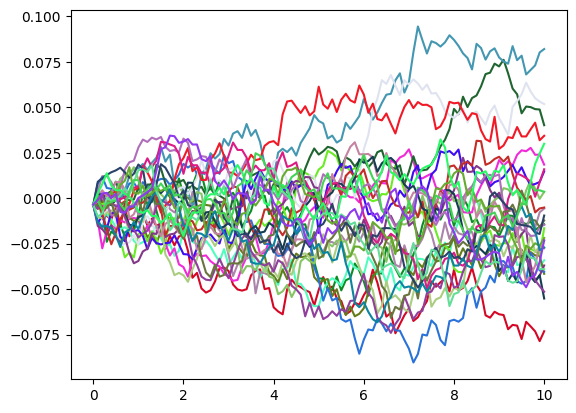

In [34]:

for i in range(len(h)):
    random_color = generate_random_color()
    #plt.scatter(ts1.cpu().numpy(), h[i].cpu().numpy(), color=random_color, label='Trajectory'+str(i))
    plt.plot(ts1.cpu().numpy(), h[i].cpu().numpy()/100, color=random_color, label='Trajectory'+str(i))
   
   
   





plt.savefig('figure8.png')
plt.show()

In [35]:
list1=[]
for i in range(len(h)):
    list1.append(h[i][-1])

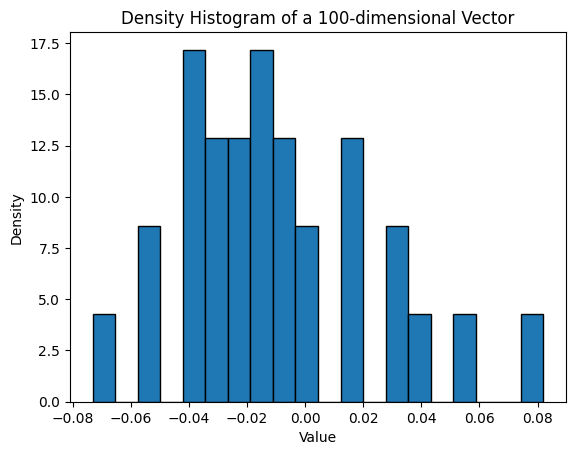

In [38]:
import torch
import matplotlib.pyplot as plt

# 创建一个100维的向量
vector = torch.tensor(list1)/100

# 将向量转换为numpy数组
vector_np = vector.numpy()

# 使用plt.hist绘制密度直方图
plt.hist(vector_np, bins=20, density=True,edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Histogram of a 100-dimensional Vector')
plt.savefig('figure5.png')
plt.show()